<a href="https://colab.research.google.com/github/S04PY/Hate-Speech-Detection/blob/main/CNN%20Hate%20Speech%20Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#importing libraries
import pandas as pd
import string
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.layers import BatchNormalization

In [3]:
#reading dataset
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

# Dropping null values
train_df = train_df.dropna(subset=['label'])
test_df = test_df.dropna(subset='tweet')

In [4]:
#abbreviation and slangs dictionary
chat_words_str = """
AFAIK=As Far As I Know
AFK=Away From Keyboard
ASAP=As Soon As Possible
ATK=At The Keyboard
ATM=At The Moment
A3=Anytime, Anywhere, Anyplace
BAK=Back At Keyboard
BBL=Be Back Later
BBS=Be Back Soon
BFN=Bye For Now
B4N=Bye For Now
BRB=Be Right Back
BRT=Be Right There
BTW=By The Way
B4=Before
B4N=Bye For Now
CU=See You
CUL8R=See You Later
CYA=See You
FAQ=Frequently Asked Questions
FC=Fingers Crossed
FWIW=For What It's Worth
FYI=For Your Information
GAL=Get A Life
GG=Good Game
GN=Good Night
GMTA=Great Minds Think Alike
GR8=Great!
G9=Genius
IC=I See
ICQ=I Seek you (also a chat program)
ILU=ILU: I Love You
IMHO=In My Honest/Humble Opinion
IMO=In My Opinion
IOW=In Other Words
IRL=In Real Life
KISS=Keep It Simple, Stupid
LDR=Long Distance Relationship
LMAO=Laugh My Ass Off
LOL=Laughing Out Loud
LTNS=Long Time No See
L8R=Later
MTE=My Thoughts Exactly
M8=Mate
NRN=No Reply Necessary
OIC=Oh I See
PITA=Pain In The Ass
PRT=Party
PRW=Parents Are Watching
ROFL=Rolling On The Floor Laughing
ROFLOL=Rolling On The Floor Laughing Out Loud
ROTFLMAO=Rolling On The Floor Laughing My Ass Off
SK8=Skate
STATS=Your sex and age
ASL=Age, Sex, Location
THX=Thank You
TTFN=Ta-Ta For Now!
TTYL=Talk To You Later
U=You
U2=You Too
U4E=Yours For Ever
WB=Welcome Back
WTF=What The Fuck
WTG=Way To Go!
WUF=Where Are You From?
W8=Wait
7K=Sick:-D Laugher
blk=black
libtard=liberal
"""

In [5]:
chat_words_map_dict = {}
chat_words_list = []
for line in chat_words_str.split("\n"):
    if line != "":
        cw = line.split("=")[0]
        cw_expanded = line.split("=")[1]
        chat_words_list.append(cw)
        chat_words_map_dict[cw] = cw_expanded
chat_words_list = set(chat_words_list)

def chat_words_conversion(text):
    new_text = []
    for w in text.split():
        if w.upper() in chat_words_list:
            new_text.append(chat_words_map_dict[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

In [6]:
def preprocessing(tweet):
    tweet = re.sub(r"http\S+", "", tweet)  # Remove URLs
    tweet = re.sub(r"@\w+", "", tweet)  # Remove mentions
    tweet = tweet.translate(tweet.maketrans('', '', string.punctuation))  # Remove punctuation
    tweet = re.sub(r'[^\x00-\x7f]', r'', tweet)  # Remove non-ASCII characters
    tweet = tweet.lower().strip()  # Convert to lowercase and strip whitespace
    tweet = re.sub(r'#\S*','', tweet)  # Remove hashtags
    tweet = re.sub(r'\brt\b', '', tweet)  # Remove 'rt' (retweet indicator)
    tweet = re.sub(r'\w*\d\w', '', tweet)  # Remove words with digits
    tweet = chat_words_conversion(tweet)

    return tweet

train_df['tweet'] = train_df['tweet'].astype(str)
test_df['tweet'] = test_df['tweet'].astype(str)

train_tweets = [preprocessing(tweet) for tweet in train_df['tweet'].tolist()]
test_tweets = [preprocessing(tweet) for tweet in test_df['tweet'].tolist()]

train_labels = pd.get_dummies(train_df['label']).values

# Tokenize and pad sequences
maxlen = 100
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_tweets)
train_sequences = tokenizer.texts_to_sequences(train_tweets)
test_sequences = tokenizer.texts_to_sequences(test_tweets)

train_data = pad_sequences(train_sequences, maxlen=maxlen)
test_data = pad_sequences(test_sequences, maxlen=maxlen)



In [7]:
#training
x_train, x_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

model = Sequential()
model.add(Embedding(max_words, 128, input_length=maxlen))
model.add(Conv1D(32, 7, activation='relu'))
model.add(BatchNormalization())
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(0.01)))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8945 - loss: 0.4503 - precision: 0.8482 - recall: 0.8676 - val_accuracy: 0.9312 - val_loss: 0.2598 - val_precision: 0.9312 - val_recall: 0.9313
Epoch 2/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9357 - loss: 0.2701 - precision: 0.9291 - recall: 0.9336 - val_accuracy: 0.9377 - val_loss: 0.2194 - val_precision: 0.9373 - val_recall: 0.9382
Epoch 3/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9426 - loss: 0.2117 - precision: 0.9391 - recall: 0.9427 - val_accuracy: 0.9448 - val_loss: 0.1877 - val_precision: 0.9446 - val_recall: 0.9445
Epoch 4/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9577 - loss: 0.1633 - precision: 0.9550 - recall: 0.9571 - val_accuracy: 0.9506 - val_loss: 0.1675 - val_precision: 0.9509 - val_recall: 0.9514
Epoch 5/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9687 - loss: 0.1284 - precision: 0.9658 - recall: 0.9684 - val_accuracy: 0.9542 - val_loss: 

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 94, 32)              │          28,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 94, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 32)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,926,568 (14.98 MB)

 Trainable params: 1,308,834 (4.99 MB)

 Non-trainable params: 64 (256.00 B)

 Optimizer params: 2,617,670 (9.99 MB)

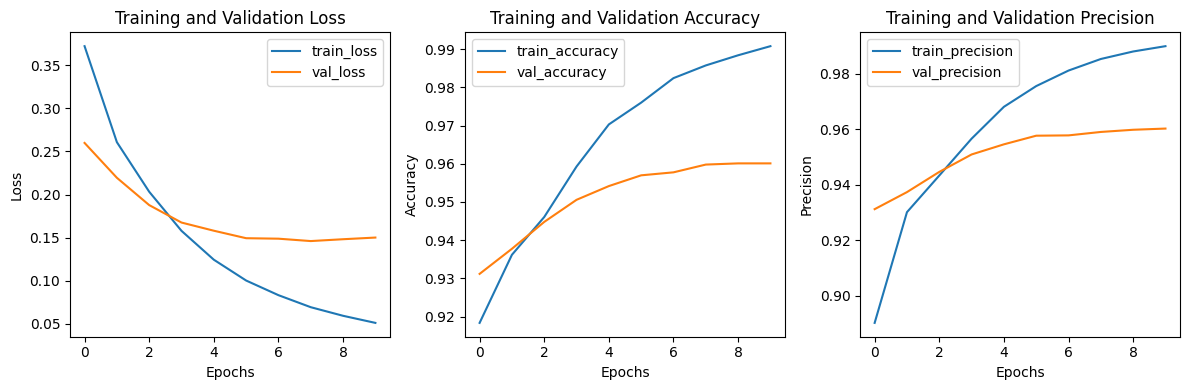

In [9]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['precision'], label='train_precision')
plt.plot(history.history['val_precision'], label='val_precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.tight_layout()
plt.show()



In [12]:
test_predictions = model.predict(test_data)
test_pred_labels = np.argmax(test_predictions, axis=1)


test_df['predicted_label'] = test_pred_labels



test_df.to_csv('/content/CNNpred.csv', index=False)

print("Predictions saved to /content/CNNpred.csv")


538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Predictions saved to /content/CNNpred.csv


In [11]:
unique_labels = train_df['label'].unique()
print(f"Unique labels in training data: {unique_labels}")


hate_speech_index = np.argmax(train_labels, axis=1).max()


num_hate_speech_tweets = np.sum(test_pred_labels == hate_speech_index)
print(f"Number of hate speech tweets in the test dataset: {num_hate_speech_tweets}")


Unique labels in training data: [0 1]
Number of hate speech tweets in the test dataset: 803
